In [6]:
%matplotlib widget
from ipywidgets import *
from astropy.io import fits
import astropy.time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv
import imutils
import re
from scipy import stats, ndimage
from scipy import asarray as ar,exp 
from scipy.optimize import curve_fit

# Open the fits cube, lightcurve data and bad pixel map

In [7]:
cube_raw = fits.open('Data/visit_PR149000_TG012001/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_RAW_SubArray_V0300.fits')
cube_raw.info()

SubArray_raw = cube_raw[1].data
#MetaData = cube[9].data

cube_raw.close()

Filename: Data/visit_PR149000_TG012001/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_RAW_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_RAW_SubArray    1 ImageHDU       108   (200, 200, 149)   int32 (rescales to uint32)   
  2  SCI_RAW_BlankLeft    1 ImageHDU        89   (8, 200, 149)   float32   
  3  SCI_RAW_BlankRight    1 ImageHDU        89   (8, 200, 149)   float32   
  4  SCI_RAW_DarkLeft    1 ImageHDU        89   (16, 200, 149)   float32   
  5  SCI_RAW_DarkRight    1 ImageHDU        89   (16, 200, 149)   float32   
  6  SCI_RAW_DarkTop    1 ImageHDU        89   (200, 3, 149)   float32   
  7  SCI_RAW_OverscanLeft    1 ImageHDU        89   (4, 200, 149)   float32   
  8  SCI_RAW_OverscanTop    1 ImageHDU        89   (200, 6, 149)   float32   
  9  SCI_RAW_ImageMetadata    1 BinTableHDU    197   149R x 38C   [1K, 26A, 1D, 1D, 1D, 1D, 1E, 1E, 1K, 26A, 1I, 1J, 1B, 1I, 1I, 5A, 1E, 1E, 1E,

## Fits cube

In [8]:
cube = fits.open('Data/Corrected_Data/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_SubArray_V0300.fits')
cube.info()

SubArray = cube[1].data
#MetaData = cube[9].data

cube.close()

Filename: Data/Corrected_Data/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_COR_SubArray    1 ImageHDU       148   (200, 200, 149)   float64   
  2  SCI_COR_ImageMetadata    1 BinTableHDU    180   149R x 41C   [26A, 1D, 1D, 8A, 1E, 1E, 8A, 8A, 1E, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1I, 1B, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D]   
  3  PIP_COR_Centroid    1 BinTableHDU     95   149R x 9C   [26A, 1D, 1D, 1I, 1E, 1E, 1E, 1E, 1B]   
  4  SCI_COR_SmearingRow    1 ImageHDU        62   (200, 1, 149)   float64   
  5  SCI_COR_SmearingRowError    1 ImageHDU        62   (200, 1, 149)   float64   


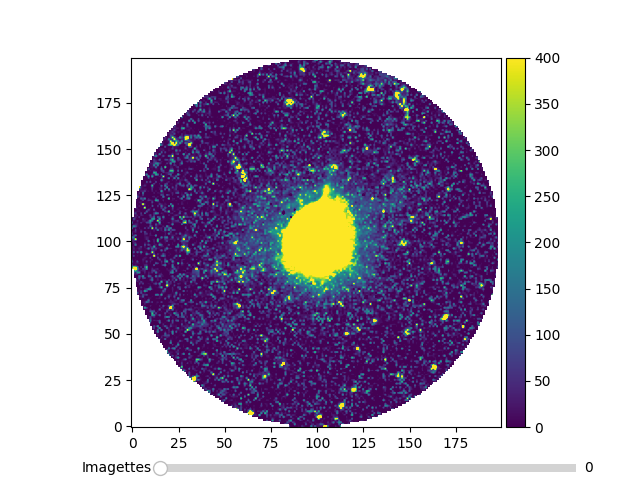

In [9]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(SubArray[39,:,:],vmin=0, vmax=400)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 148, valstep=1)

def update(val):
    array = SubArray[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()


'''
axbutton_next = plt.axes([0.85, 0.1, 0.1, 0.05])
axbutton_prev = plt.axes([0.05, 0.1, 0.1, 0.05])
               
button_next = Button(axbutton_next, 'Next')
button_prev = Button(axbutton_prev, 'Previous')


def next(val):
    pos = slider.val
    slider.set_val(SubArray[pos+1,:,:])
    ax.imshow(array).canvas.draw_idle()
    ax.invert_yaxis()

def previous(val):
    pos = slider.val
    slider.set_value(SubArray[pos-1,:,:])
    ax.imshow(array).canvas.draw_idle()
    ax.invert_yaxis()


class Index:
    index = 0
    def next(self, event):
        self.index += 1
        i = self.index % 148
        array = SubArray[i,:,:]
        ax.imshow(array)
        ax.invert_yaxis()
    
    def previous(val):
        self.index -= 1
        i = self.index % 148
        array = SubArray[i,:,:]
        ax.imshow(array)
        ax.invert_yaxis()

callback = Index()
button_next.on_clicked(callback.next)
button_prev.on_clicked(callback.previous)
'''
slider.on_changed(update)
plt.show()
#plt.savefig("Cheops_w_cosmics.png")

In [10]:
plt.close()

## Lightcurve data

In [11]:
lightcurve = 'Data/visit_PR149000_TG012001/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_Lightcurve-DEFAULT_V0300.fits'
lightcurve_file = fits.open(lightcurve)
lightcurve_data = lightcurve_file[1].data
lightcurve_header = lightcurve_file[1].header
lightcurve_file.close()

time = lightcurve_data['BJD_TIME']
roll_angle = lightcurve_data['ROLL_ANGLE']

## Bad pixel map

In [12]:
pixel_cube = fits.open('Data/visit_PR149000_TG012001/CH_TU2023-12-25T09-10-01_REF_APP_BadPixelMap_V0300.fits')
pixel_cube.info()
BadPixelMap = pixel_cube[1].data
pixel_cube.close()

Filename: Data/visit_PR149000_TG012001/CH_TU2023-12-25T09-10-01_REF_APP_BadPixelMap_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  REF_APP_BadPixelMap    1 ImageHDU        58   (1024, 1024)   int16   
  2  REF_APP_BadPixelMapLeft    1 ImageHDU        42   (16, 1024)   int16   
  3  REF_APP_BadPixelMapRight    1 ImageHDU        42   (16, 1024)   int16   
  4  REF_APP_BadPixelMapTop    1 ImageHDU        42   (1024, 3)   int16   
  5  REF_APP_PhotPixelMap    1 ImageHDU        35   (1024, 1024)   uint8   
  6  REF_APP_PhotPixelMapLeft    1 ImageHDU        36   (16, 1024)   uint8   
  7  REF_APP_PhotPixelMapRight    1 ImageHDU        36   (16, 1024)   uint8   
  8  REF_APP_PhotPixelMapTop    1 ImageHDU        36   (1024, 3)   uint8   


# Defining mean and median

In [13]:
median = np.median(SubArray[:,:,:], axis=0)
mean = np.mean(SubArray[:,:,:], axis=0)

subtract = np.array(np.broadcast_to(median,np.shape(SubArray)))

cleaned_SubArray = SubArray - subtract

# Make a histogram

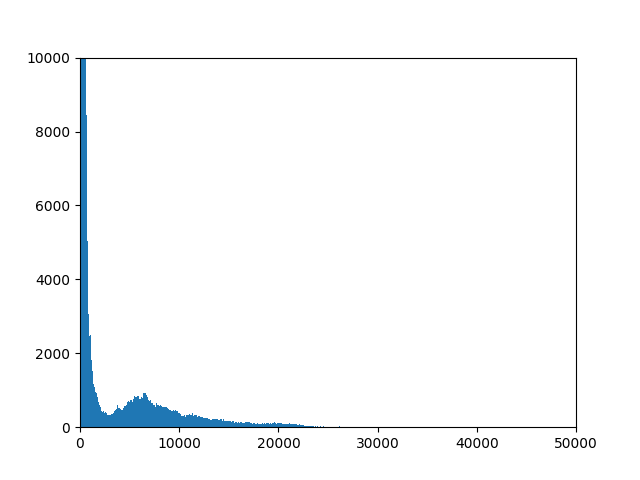

In [14]:
#reshape array from 3d to 2d
flattened_Array = np.ndarray.flatten(SubArray)
#plot a histogram
plt.figure()
plt.hist(flattened_Array, bins=800)
plt.ylim(top=10000)
plt.xlim(left = 0, right=50000)
plt.show()

In [15]:
plt.close()

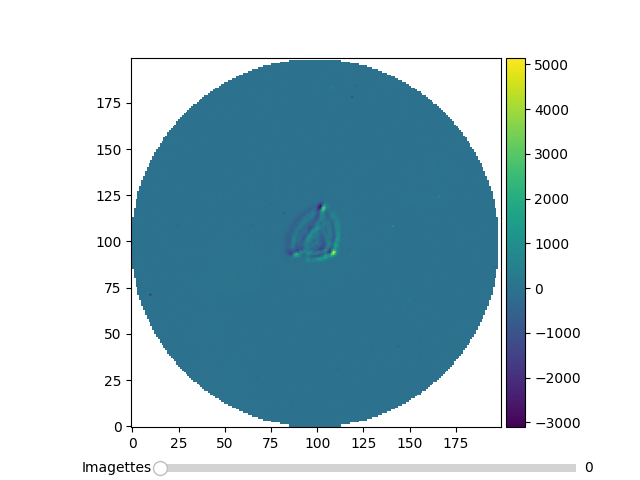

In [16]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(cleaned_SubArray[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 148, valstep=1)

def update(val):
    array = cleaned_SubArray[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)

plt.show()

In [17]:
plt.close()

# Preprocessing

In [18]:
# replace NaN values with 0

def nan_to_0(input_array):
    input_array[np.isnan(input_array)] = 0
    return(input_array)

SubArray_corr = nan_to_0(SubArray)

In [19]:
#test
#compute temporal median for one pixel only

temp_pix = np.nanmedian(SubArray_corr[:,55,135], axis=0)

print(temp_pix)

-4.30641775206567


In [20]:
#compute temporal median for each pixel

def pixel_medians(input):
    pixels = np.empty(shape=(200,200))
    for j in range(len(input[0,:,0])):
        for k in range(len(input[0,0,:])):
            pixels[j,k] = np.nanmedian(input[:,j,k], axis=0)
    return(pixels)

temporal_median = pixel_medians(SubArray)
#print(temporal_median)

temporal_broadcast = np.array(np.broadcast_to(temporal_median,np.shape(SubArray)))
#print(temporal_broadcast.shape)

#subtract temporal median from cube
SubArray_new = SubArray - temporal_broadcast


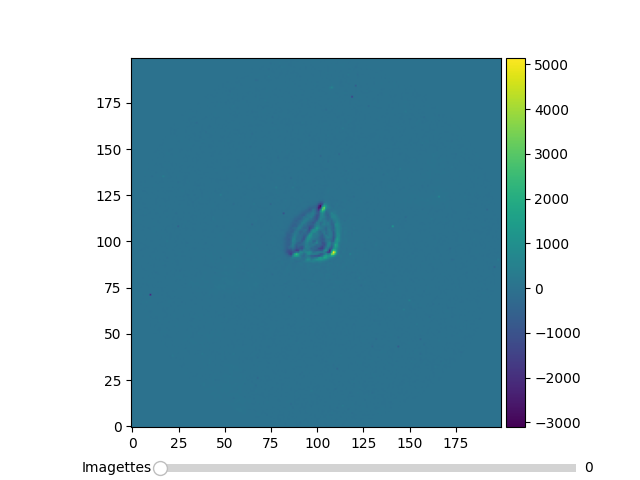

In [21]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(SubArray_new[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 148, valstep=1)

def update(val):
    array = SubArray_new[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)


plt.show()

In [22]:
plt.close()

# Derotate image

In [23]:
def roll_angle_correction(data_array, roll_angle_array):
    rotated_array = np.empty(shape=(0,200,200))
    example_shape_array = np.empty(shape=(1,200,200))
    for i in range(len(data_array[:,0,0])):
        rotated_image = np.full_like(example_shape_array,ndimage.rotate(data_array[i,:,:], -roll_angle_array[i], reshape=False))
        rotated_array = np.concatenate((rotated_array, rotated_image))
    
    return(rotated_array)
        
derotated_cube = roll_angle_correction(SubArray_new, roll_angle)

print(derotated_cube[44,0,80])

-0.8103905455494258


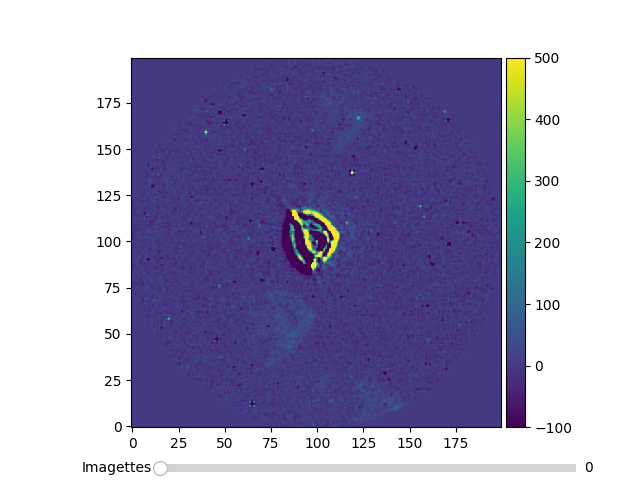

In [24]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(derotated_cube[0,:,:], vmin=-100, vmax=500,)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 149, valstep=1)

def update(val):
    array = derotated_cube[val,:,:]
    ax.imshow(array, vmin=-100, vmax=500)
    ax.invert_yaxis()
slider.on_changed(update)

plt.show()

In [25]:
plt.close()

# Create mask

In [26]:
# calculate new mean/median

mean_new = np.mean(derotated_cube[:,:,:], axis=0)
median_new = np.median(derotated_cube[:,:,:]**2, axis=0)

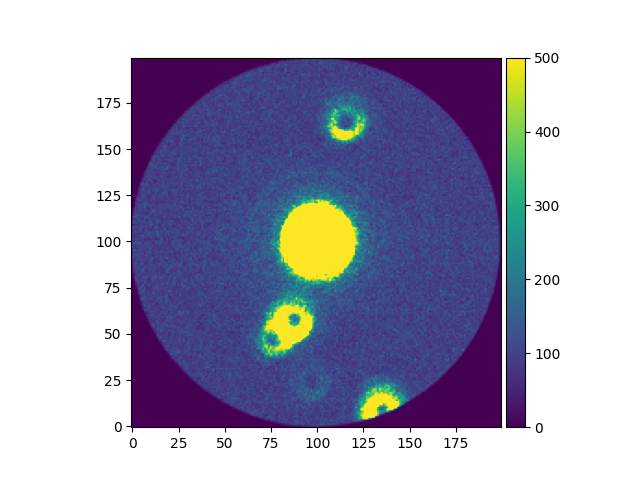

In [27]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(median_new, vmin=0, vmax=500,)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()

'''
axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 149, valstep=1)

def update(val):
    array = derotated_cube[val,:,:]
    ax.imshow(array, vmin=-100, vmax=500)
    ax.invert_yaxis()
slider.on_changed(update)
'''
plt.show()

In [28]:
plt.close()

## Make a histogram and fit a Gaussian

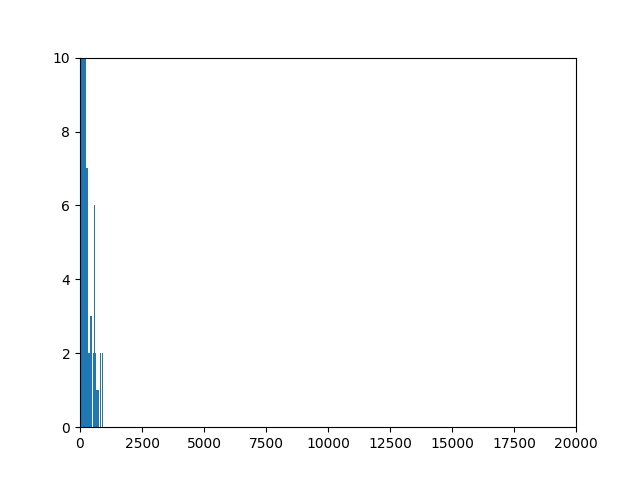

In [29]:
#reshape array from 3d to 2d
flattened_Array = np.ndarray.flatten(median_new)

#plot a histogram
plt.figure()
plt.hist(flattened_Array, bins=1000, range=(0, 1000))
plt.ylim(top=10)
plt.xlim(left=0, right=20000)
plt.show()

In [30]:
plt.close()

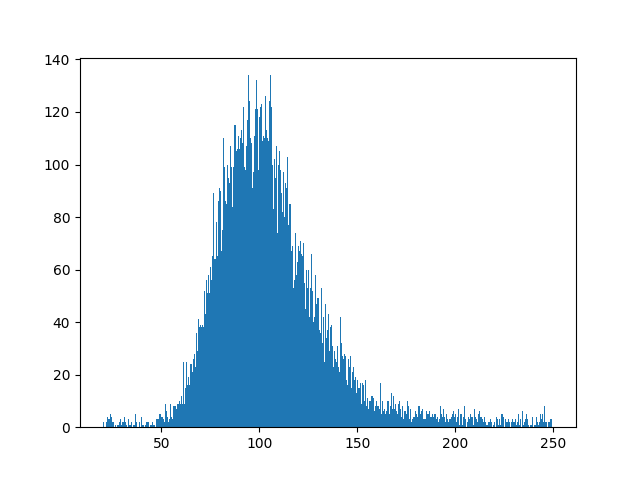

In [31]:
#cut off outliers until x=20 -> range now: 20 - 250

flattened_Array_Gauss = [i for i in flattened_Array if (i >= 20) and (i <= 250)]

plt.figure()
plt.hist(flattened_Array_Gauss, bins=1000)
plt.show()

In [32]:
plt.close()

amp 113.98327001444585
mean 99.5463689625629
sigma 0.04660729302233461


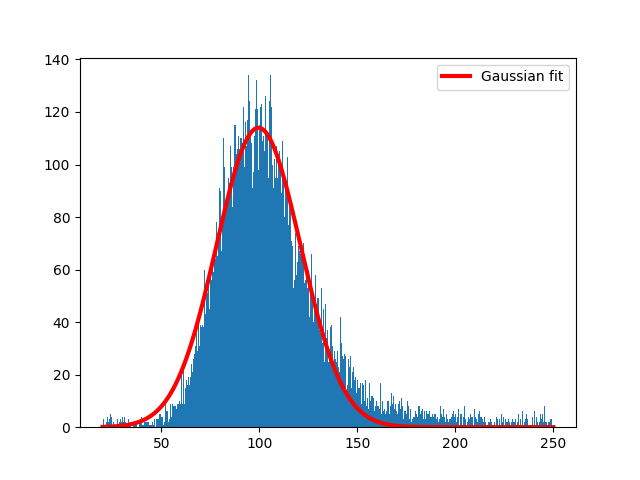

In [33]:
n, bins, patches = plt.hist(flattened_Array_Gauss, bins=1000)
x = np.linspace(20,250,1000)
y = n

mu = np.mean(flattened_Array_Gauss)
std = np.std(flattened_Array_Gauss)

def gauss(x,amp,mu,sigma):
    return amp*np.exp(-(x-mu)**2/2*sigma**2)

popt,pcov=curve_fit(gauss,x,y,p0=[120, mu, std])

plt.plot(x,gauss(x,*popt),color='red',lw= 3,label='Gaussian fit')
print('amp',popt[0])
print('mean',popt[1])
print('sigma',popt[2])
plt.legend()
plt.show()

In [34]:
plt.close()

### Mask


In [35]:
mask = np.zeros(np.shape(median_new))
mask[median_new > 160] = 1

kernel = np.ones((3,3), dtype=np.uint8)
enlarged_mask = cv.dilate(mask, kernel, iterations=1)

In [36]:
def apply_mask(data, mask):
    masked_cube = np.ma.masked_where(mask == 1, data)
    return(masked_cube)

broadcast_mask = np.array(np.broadcast_to(enlarged_mask,np.shape(median_new)))
median_mask = apply_mask(median_new, broadcast_mask)

mask = np.zeros(np.shape(median_mask))
mask[median_mask > 160] = 1

median_broadcast = np.array(np.broadcast_to(mask,np.shape(derotated_cube)))
cube_mask = apply_mask(derotated_cube, median_broadcast)

#print(cube_mask[0,100,:])

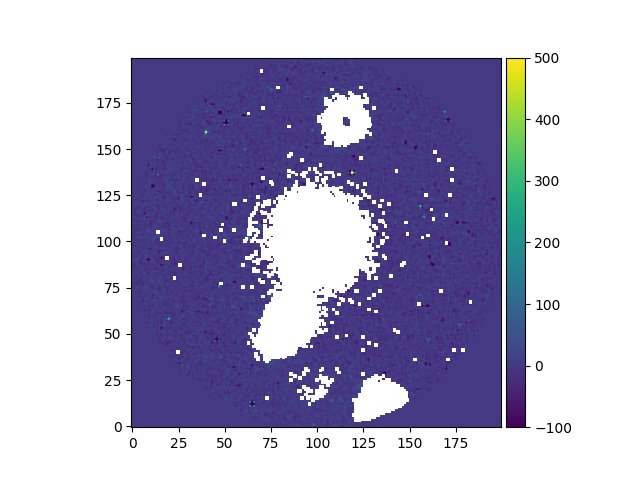

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(cube_mask[0,:,:], vmin=-100, vmax=500, animated=True)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()

'''
axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 148, valstep=1)

def update(val):
    array = cube_mask[val,:,:]
    ax.imshow(array,vmin=-100, vmax=500)
    ax.invert_yaxis()
slider.on_changed(update)


def update(i):
    im.set_array(cube_mask[i,:,:])
    return im
'''
#animation_figure = animation.FuncAnimation(fig, update, frames=148, interval=200, blit=True,repeat_delay=10)

plt.show()
#animation_figure.save("Rotation.gif")

In [38]:
plt.close()

# Filepaths
 Hardcoded for now -> will write a function to fill the arrays later

In [39]:
paths_lightcurve_hardcoded = ['./Data/visits/CH_PR100012_TG003904_TU2023-06-02T08-22-09_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
                    './Data/visits/CH_PR100016_TG014609_TU2024-02-21T12-37-10_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
                    './Data/visits/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
                    './Data/visits/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
                    './Data/visits/CH_PR230034_TG000402_TU2023-11-02T01-29-10_SCI_COR_Lightcurve-DEFAULT_V0300.fits',
                   ]
paths_subarray_hardcoded = ['./Data/visits/CH_PR100012_TG003904_TU2023-06-02T08-22-09_SCI_COR_SubArray_V0300.fits',
                  './Data/visits/CH_PR100016_TG014609_TU2024-02-21T12-37-10_SCI_COR_SubArray_V0300.fits',
                  './Data/visits/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_SubArray_V0300.fits',
                  './Data/visits/CH_PR149000_TG012001_TU2023-12-14T20-44-29_SCI_COR_SubArray_V0300.fits',
                  './Data/visits/CH_PR230034_TG000402_TU2023-11-02T01-29-10_SCI_COR_SubArray_V0300.fits'
                 ]

# It's the final function(s)

In [44]:
# write a fruntion to do the above things

def get_data(paths_subarray):
    for path_subarray in paths_subarray:
        path_lightcurve = re.sub('SubArray','Lightcurve-DEFAULT',path_subarray)
        
get_data(paths_subarray_hardcoded)
def nan_to_0(input_array):
    input_array[np.isnan(input_array)] = 0
    return(input_array)

def pixel_medians(input):
    pixels = np.empty(shape=(200,200))
    for j in range(len(input[0,:,0])):
        for k in range(len(input[0,0,:])):
            pixels[j,k] = np.nanmedian(input[:,j,k], axis=0)
    return(pixels)

def roll_angle_correction(data_array, roll_angle_array):
    rotated_array = np.empty(shape=(0,200,200))
    example_shape_array = np.empty(shape=(1,200,200))
    for i in range(len(data_array[:,0,0])):
        rotated_image = np.full_like(example_shape_array,ndimage.rotate(data_array[i,:,:], -roll_angle_array[i], reshape=False))
        rotated_array = np.concatenate((rotated_array, rotated_image))
    
    return(rotated_array)

def apply_mask(data, mask):
    masked_cube = np.ma.masked_where(mask == 1, data)
    return(masked_cube)
    

def mask_and_rotate(data, roll_angle):
    #preprocessing
    corrected_data = nan_to_0(data)
    temporal_median = pixel_medians(data)
    temporal_broadcast = np.array(np.broadcast_to(temporal_median,np.shape(data)))
    data_array_new = data - temporal_broadcast

    #rotation
    derotated_cube = roll_angle_correction(data_array_new, roll_angle)

    #masking
    mean = np.mean(derotated_cube[:,:,:]**2, axis=0)
    median = np.median(derotated_cube[:,:,:]**2, axis=0)

    initial_mask = np.zeros(np.shape(median))
    initial_mask[median > 180] = 1

    kernel = np.ones((3,3), dtype=np.uint8)
    enlarged_mask = cv.dilate(initial_mask, kernel, iterations=1)

    broadcast_mask = np.array(np.broadcast_to(enlarged_mask,np.shape(median)))
    median_mask = apply_mask(median, broadcast_mask)

    mask = np.zeros(np.shape(median_mask))
    mask[median_mask > 180] = 1

    median_broadcast = np.array(np.broadcast_to(mask,np.shape(derotated_cube)))
    cube_mask = apply_mask(derotated_cube, median_broadcast)

    return(cube_mask)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


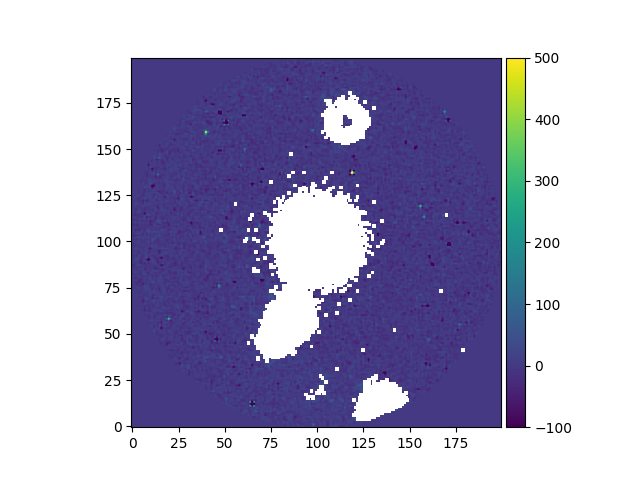

In [25]:
PR149000_TG012001 = mask_and_rotate(SubArray, roll_angle)


fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(PR149000_TG012001[0,:,:], vmin=-100, vmax=500, animated=True)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()
plt.show()

In [65]:
plt.close()

In [66]:
PR149000_TG009801 = fits.open('Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_RAW_SubArray_V0300.fits')
PR149000_TG009801.info()

SubArray_1 = PR149000_TG009801[1].data
#MetaData = cube[9].data

PR149000_TG009801.close()

Filename: Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_RAW_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_RAW_SubArray    1 ImageHDU       108   (200, 200, 224)   int32 (rescales to uint32)   
  2  SCI_RAW_BlankLeft    1 ImageHDU        89   (8, 200, 224)   float32   
  3  SCI_RAW_BlankRight    1 ImageHDU        89   (8, 200, 224)   float32   
  4  SCI_RAW_DarkLeft    1 ImageHDU        89   (16, 200, 224)   float32   
  5  SCI_RAW_DarkRight    1 ImageHDU        89   (16, 200, 224)   float32   
  6  SCI_RAW_DarkTop    1 ImageHDU        89   (200, 3, 224)   float32   
  7  SCI_RAW_OverscanLeft    1 ImageHDU        89   (4, 200, 224)   float32   
  8  SCI_RAW_OverscanTop    1 ImageHDU        89   (200, 6, 224)   float32   
  9  SCI_RAW_ImageMetadata    1 BinTableHDU    197   224R x 38C   [1K, 26A, 1D, 1D, 1D, 1D, 1E, 1E, 1K, 26A, 1I, 1J, 1B, 1I, 1I, 5A, 1E, 1E, 1E,

In [67]:
lightcurve_PR149000_TG009801 = 'Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_Lightcurve-DEFAULT_V0300.fits'
lightcurve_file = fits.open(lightcurve_PR149000_TG009801)
lightcurve_data = lightcurve_file[1].data
lightcurve_header = lightcurve_file[1].header
lightcurve_file.close()

time = lightcurve_data['BJD_TIME']
roll_angle_1 = lightcurve_data['ROLL_ANGLE']

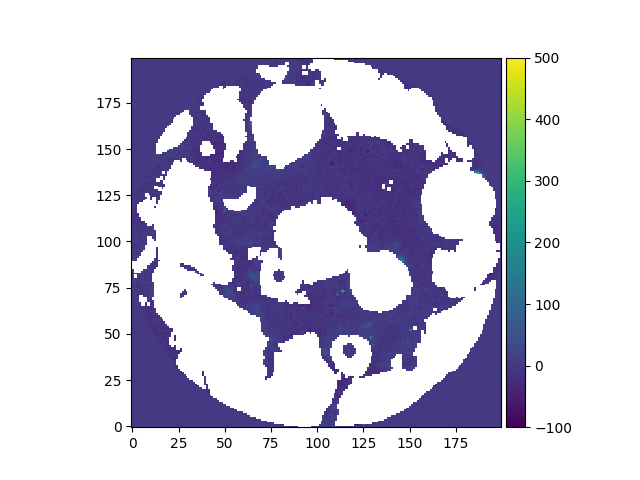

In [68]:
visit_PR149000_TG009801 = mask_and_rotate(SubArray_1, roll_angle_1)


fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(visit_PR149000_TG009801[0,:,:], vmin=-100, vmax=500, animated=True)
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()
plt.show()

In [69]:
plt.close()